In [1]:
import numpy as np  
from keras.layers import Input, Dense
from keras.models import Model
from keras.models import load_model
from processing_functions import * 

import os
os.chdir('../') # Go to the parent folder
from support_functions import *
from Autoencoder_Functions import *
os.chdir('MNIST')

Using TensorFlow backend.


## Parameters

In [2]:
anomaly_digit = 2 # Set digit 2 as our anomaly
n_components=30 # 30 components in the encoded matrix
k = 50 # Define the k parameter for the precision at k

## Read Data

In [3]:
data_path = 'data/input_data/'
# Read image matrix (n*m), labels (vector of m), and image size
imgs_train, imgs_test, labels_train, labels_test, height, width = read_process_data(data_path, anomaly_digit)
# The length of one image vector
img_size = height*width 

### Load the Saved Models
#### Autoencoder Model

In [4]:
# Generate and Compile a Deep Autoencoder
# Specify the model config
encoder_layers_size, decoder_layers_size = get_deep_model_config(img_size)
# Extract the saved model
autoencoder, encoder = compile_autoencoder(img_size,encoder_layers_size, decoder_layers_size) 
autoencoder = load_model('model_autoencoder.h5') # Load the saved model

#### Encoder Model
Encoder is the first half of the autoencoder model and it is not compiled; thus, we retrieve the encoder model based on the autoencoder one. 

In [5]:
weights_encoder = autoencoder.get_weights()[0:4] # The first half of the autoencoder model is an encoder model
encoder.set_weights(weights_encoder) # Set weights

In [6]:
print(encoder.summary())
print("\n The output shape of the encoder model: ")
print(encoder.output_shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
Total params: 697,280
Trainable params: 697,280
Non-trainable params: 0
_________________________________________________________________
None

 The output shape of the encoder model: 
(None, 64)


### Visualize the Reconstructed Image

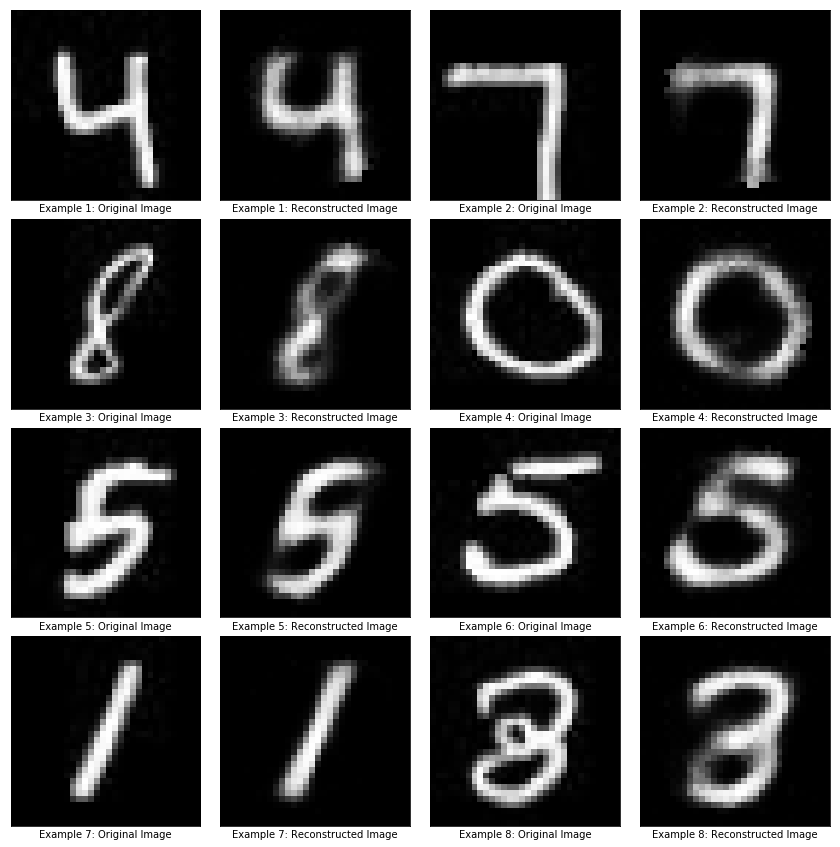

In [7]:
imgs_train_reconstructed,imgs_train = reconstruct_with_autoencoder(autoencoder,imgs_train,visual =True,height = height, width = width)

## Implement the Anomaly Detection with the Gaussian Distribution

### Encode the images in the Training Set and the Testing Set

In [8]:
imgs_train_encoded = encode_data(encoder, imgs_train)
imgs_test_encoded = encode_data(encoder, imgs_test)

### Visualize the Distribution of Data Points in the encoded matrix

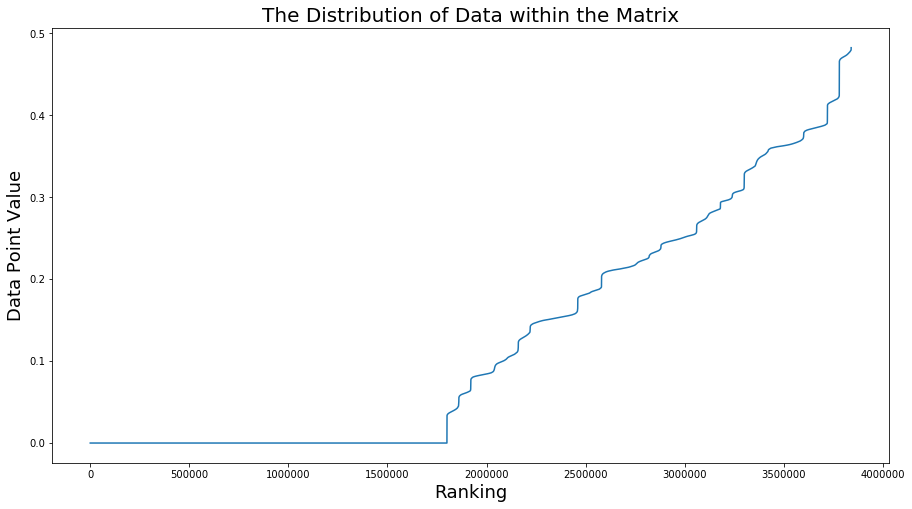

In [9]:
plot_matrix_data(imgs_train_encoded)

### Detector

Finish evaluate Lambda: 0
Finish evaluate Lambda: 0.09
Finish evaluate Lambda: 0.18
Finish evaluate Lambda: 0.27
Finish evaluate Lambda: 0.36
Finish evaluate Lambda: 0.44999999999999996
Finish evaluate Lambda: 0.5399999999999999
Finish evaluate Lambda: 0.6299999999999999
Finish evaluate Lambda: 0.7199999999999999
Finish evaluate Lambda: 0.8099999999999998
Finish evaluate Lambda: 0.8999999999999998
Finish evaluate Lambda: 0.9899999999999998


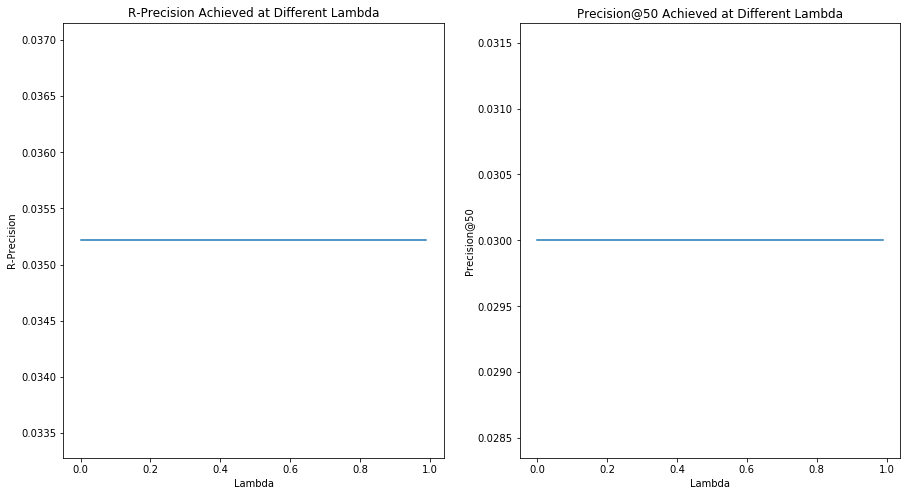

The best lambda selected from the cross validation is: 0.44999999999999996


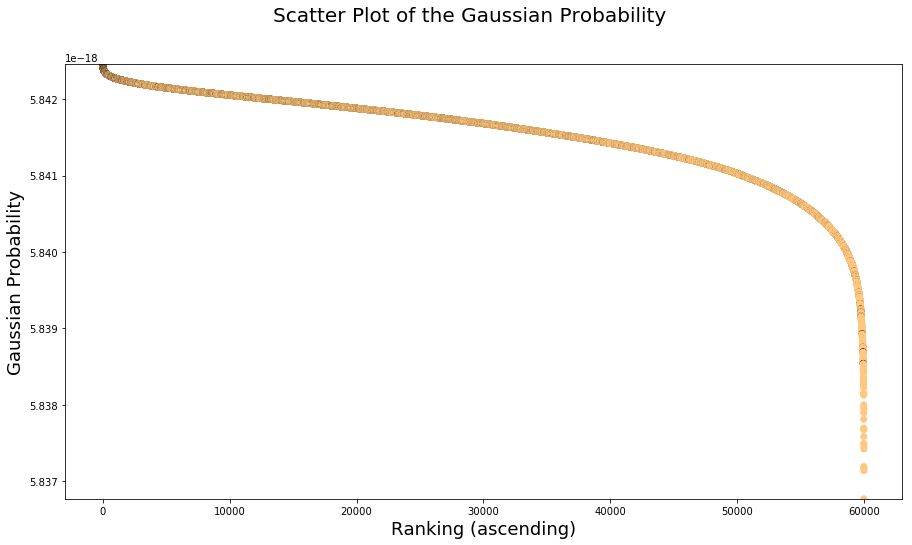

Training Results:
Precision: 9.9%
Recall: 99.8%
F-score: 18.0%
R-Precision (# R = 5958.0): 3.5%
Precision@50: 0.0%

Precision: 10.3%
Recall: 100.0%
F-score: 18.7%
R-Precision (# R = 1032.0): 9.2%
Precision@50: 4.0%


In [10]:
train_test_with_gaussian(imgs_train_encoded, imgs_test_encoded, labels_train, labels_test,k,whitened = True, plot_comparison = True)